# RAID Robustness Analysis Based on AFR
## 2025/02/17 kennel.org


- The notebook calculates and compares failure rates of RAID1, RAID5, RAID6, and single disk setups over 5 years.  
- It includes functions and simulations for these calculations.  
- Both theoretical methods and Monte Carlo simulations are used.  
- The results are visualized through plotted graphs.  
- The program also identifies intersection points between single disk and RAID failure rates.  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve


# Define functions for RAID and single disk failure rates
def single_disk_failure_rate(annual_failure_rate, years=5):
    return 1 - (1 - annual_failure_rate) ** years


def raid1_failure_rate(annual_failure_rate, years=5, num_disks=2):
    survival_rate_per_disk = (1 - annual_failure_rate) ** years
    failure_rate_per_disk = 1 - survival_rate_per_disk
    p_0_failures = survival_rate_per_disk**num_disks
    p_1_failure = (
        num_disks * (survival_rate_per_disk ** (num_disks - 1)) * failure_rate_per_disk
    )
    p_2_or_more_failures = 1 - (p_0_failures + p_1_failure)
    return p_2_or_more_failures


def raid5_failure_rate(annual_failure_rate, years=5, num_disks=5):
    survival_rate_per_disk = (1 - annual_failure_rate) ** years
    failure_rate_per_disk = 1 - survival_rate_per_disk
    p_0_failures = survival_rate_per_disk**num_disks
    p_1_failure = (
        num_disks * (survival_rate_per_disk ** (num_disks - 1)) * failure_rate_per_disk
    )
    p_2_or_more_failures = 1 - (p_0_failures + p_1_failure)
    return p_2_or_more_failures


def raid6_failure_rate_6_disks(annual_failure_rate, years=5, num_disks=6):
    survival_rate_per_disk = (1 - annual_failure_rate) ** years
    failure_rate_per_disk = 1 - survival_rate_per_disk
    p_0_failures = survival_rate_per_disk**num_disks
    p_1_failure = (
        num_disks * (survival_rate_per_disk ** (num_disks - 1)) * failure_rate_per_disk
    )
    p_2_failures = (
        (num_disks * (num_disks - 1) / 2)
        * (survival_rate_per_disk ** (num_disks - 2))
        * (failure_rate_per_disk**2)
    )
    p_3_or_more_failures = 1 - (p_0_failures + p_1_failure + p_2_failures)
    return p_3_or_more_failures

In [2]:
# Monte Carlo simulation for RAID failure rates
def simulate_raid_failure_v3(
    annual_failure_rate, years, num_disks, raid_type, num_simulations=100000
):
    failures = 0
    for _ in range(num_simulations):
        disk_failures = np.random.rand(num_disks, years) < annual_failure_rate
        total_failures_per_disk = disk_failures.sum(axis=1)

        if raid_type == "RAID1":  # RAID1 fails if 2 disks fail
            if np.count_nonzero(total_failures_per_disk >= 1) >= 2:
                failures += 1
        elif raid_type == "RAID5":  # RAID5 fails if 2 or more disks fail
            if np.count_nonzero(total_failures_per_disk >= 1) >= 2:
                failures += 1
        elif raid_type == "RAID6":  # RAID6 fails if 3 or more disks fail
            if np.count_nonzero(total_failures_per_disk >= 1) >= 3:
                failures += 1
        elif raid_type == "SingleDisk":  # Single disk fails if one disk fails
            if np.count_nonzero(total_failures_per_disk >= 1) >= 1:
                failures += 1
    return failures / num_simulations

In [3]:
# Function to find intersection between two failure rates
def find_intersection_with_initial_guess(raid_rate, initial_guess):
    return fsolve(lambda x: single_disk_failure_rate(x) - raid_rate(x), initial_guess)[
        0
    ]


# Generate failure rates and calculate theoretical values
failure_rates_full = np.linspace(0, 0.2, 21)  # 0% to 20% in 1% increments
failure_rates_percentage = [5, 10, 20]
years = 5
num_simulations = 100000

# Theoretical failure rates for Single Disk, RAID1, RAID5, and RAID6
single_disk_failure_rates = [single_disk_failure_rate(f) for f in failure_rates_full]
raid1_failure_rates = [raid1_failure_rate(f) for f in failure_rates_full]
raid5_failure_rates = [raid5_failure_rate(f) for f in failure_rates_full]
raid6_failure_rates = [raid6_failure_rate_6_disks(f) for f in failure_rates_full]

# Run Monte Carlo simulations
single_disk_mc_v3 = [
    simulate_raid_failure_v3(f / 100, years, 1, "SingleDisk", num_simulations)
    for f in failure_rates_percentage
]
raid1_mc_v3 = [
    simulate_raid_failure_v3(f / 100, years, 2, "RAID1", num_simulations)
    for f in failure_rates_percentage
]
raid5_mc_v3 = [
    simulate_raid_failure_v3(f / 100, years, 5, "RAID5", num_simulations)
    for f in failure_rates_percentage
]
raid6_mc_v3 = [
    simulate_raid_failure_v3(f / 100, years, 6, "RAID6", num_simulations)
    for f in failure_rates_percentage
]

# Find intersection points using improved initial guess
initial_guess_raid5 = 0.03  # 3% initial guess for RAID5
initial_guess_raid6 = 0.08  # 8% initial guess for RAID6
intersection_raid5_corrected = find_intersection_with_initial_guess(
    raid5_failure_rate, initial_guess_raid5
)
intersection_raid6_corrected = find_intersection_with_initial_guess(
    raid6_failure_rate_6_disks, initial_guess_raid6
)
intersection_raid5_corrected_value = (
    single_disk_failure_rate(intersection_raid5_corrected) * 100
)
intersection_raid6_corrected_value = (
    single_disk_failure_rate(intersection_raid6_corrected) * 100
)

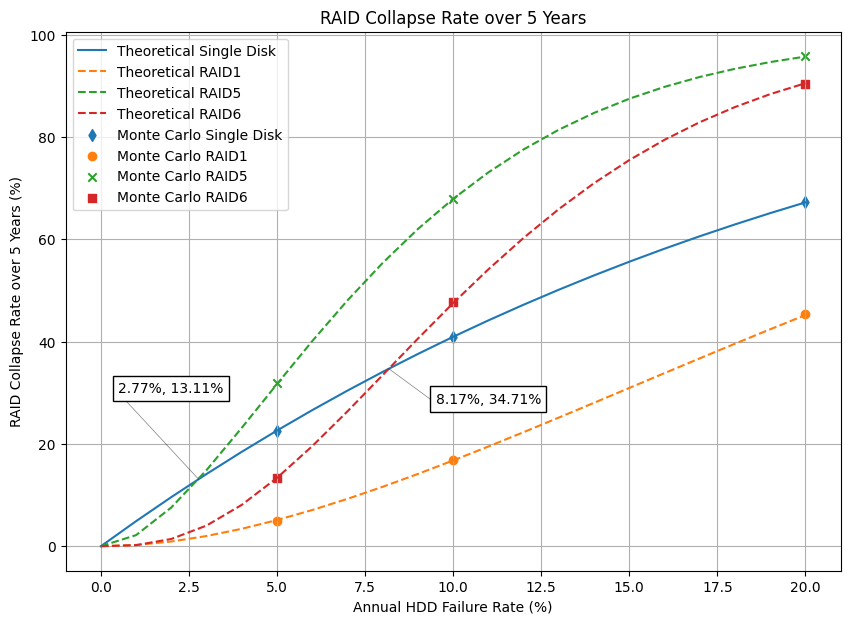

In [4]:
# Re-plot with corrected intersection points and adjust the text box positions as previously instructed
plt.figure(figsize=(10, 7))

# Single disk
plt.plot(
    failure_rates_full * 100,
    np.array(single_disk_failure_rates) * 100,
    label="Theoretical Single Disk",
    linestyle="-",
    color="tab:blue",
)
# RAID1
plt.plot(
    failure_rates_full * 100,
    np.array(raid1_failure_rates) * 100,
    label="Theoretical RAID1",
    linestyle="--",
    color="tab:orange",
)
# RAID5
plt.plot(
    failure_rates_full * 100,
    np.array(raid5_failure_rates) * 100,
    label="Theoretical RAID5",
    linestyle="--",
    color="tab:green",
)
# RAID6
plt.plot(
    failure_rates_full * 100,
    np.array(raid6_failure_rates) * 100,
    label="Theoretical RAID6",
    linestyle="--",
    color="tab:red",
)

# Monte Carlo simulation points
plt.scatter(
    failure_rates_percentage,
    np.array(single_disk_mc_v3) * 100,
    label="Monte Carlo Single Disk",
    marker="d",
    color="tab:blue",
)
plt.scatter(
    failure_rates_percentage,
    np.array(raid1_mc_v3) * 100,
    label="Monte Carlo RAID1",
    marker="o",
    color="tab:orange",
)
plt.scatter(
    failure_rates_percentage,
    np.array(raid5_mc_v3) * 100,
    label="Monte Carlo RAID5",
    marker="x",
    color="tab:green",
)
plt.scatter(
    failure_rates_percentage,
    np.array(raid6_mc_v3) * 100,
    label="Monte Carlo RAID6",
    marker="s",
    color="tab:red",
)

# Annotate corrected intersection points with previous text box positions
plt.text(
    0.5,
    30,
    f"{intersection_raid5_corrected*100:.2f}%, {intersection_raid5_corrected_value:.2f}%",
    bbox=dict(facecolor="white", edgecolor="black"),
    fontsize=10,
)

plt.text(
    9.5,
    28,
    f"{intersection_raid6_corrected*100:.2f}%, {intersection_raid6_corrected_value:.2f}%",
    bbox=dict(facecolor="white", edgecolor="black"),
    fontsize=10,
)

# Simple lines from text boxes to intersection points
plt.plot(
    [0.5, intersection_raid5_corrected * 100],
    [30, intersection_raid5_corrected_value],
    "k-",
    lw=0.5,
    alpha=0.5,
)
plt.plot(
    [9.5, intersection_raid6_corrected * 100],
    [28, intersection_raid6_corrected_value],
    "k-",
    lw=0.5,
    alpha=0.5,
)

# Labels and titles
plt.xlabel("Annual HDD Failure Rate (%)")
plt.ylabel("RAID Collapse Rate over 5 Years (%)")
plt.title("RAID Collapse Rate over 5 Years")
plt.grid(True)
plt.legend()

# Show plot
plt.show()